# Scenario Comparison Analysis

This notebook provides an interactive GUI for comparing two simulation scenarios side-by-side.

**Note:** Both scenarios being compared share the same topology and ISP subgraphs.
The comparison shows how different routing strategies (e.g., disaster-aware vs. standard routing) affect the same network.

## Features:

1. **Scenario Selection**: Load and compare any two scenarios from the output folder
2. **View Modes**:
   - **Topology View**: Compare ISP subgraphs in normal/disaster mode
   - **Statistics View**: Compare metrics with filtering and multiple visualization types
3. **Filtering Options**: No Filter, Migration Traffic Only, Exclude Migration Traffic, By ISP, By Node
4. **Visualization Types**: Blocking Probability, Availability, Link Utilization, Network Usage
5. **Dynamic Controls**: Time bucket slider for temporal analyses, Top N Links slider for link utilization (auto-adjusts to total link count)
6. **Timing Markers**: ISP Migration Start Times and Disaster Period
7. **Smart Caching**: Plots are cached automatically - switching between views or scenarios without changing parameters reuses cached plots for faster navigation

## 1. Setup and Imports

In [1]:
from pathlib import Path
import ast

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output

# Enable autoreload for module changes
%load_ext autoreload
%autoreload 2

# Import analysis and visualization functions from modules
from simulador.analysis.scenario_comparison import (
    load_scenario_pair,
    apply_filter,
    create_comparison_data,
    create_multi_scenario_comparison_data
)

from simulador.visualization.comparison_plots import (
    plot_blocking_probability_comparison,
    plot_availability_comparison,
    plot_link_utilization_comparison,
    plot_network_usage_comparison,
    visualize_isp_topology_comparison,
    visualize_isp_topology,
    plot_blocking_probability_multi,
    plot_availability_multi,
    plot_link_utilization_multi,
    plot_network_usage_multi
)

from simulador.visualization.comparison_table import (
    create_comparison_table_widget,
    create_multi_scenario_table_widget
)

import pickle

# Style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 8)

print("✓ All modules loaded successfully!")

✓ All modules loaded successfully!


## 2. Interactive GUI

The GUI provides:
- Scenario selection dropdowns
- View mode toggle (Topology vs Statistics)
- Filtering options
- Visualization controls
- Timing marker toggles

In [2]:
def create_comparison_gui():
    """
    Create the main comparison GUI.
    """
    # Find available scenarios - scan both direct files and subdirectories
    output_path = Path("output")
    scenario_paths = {}  # Maps scenario_name -> {'pkl': path, 'csv': path}
    
    # Pattern 1: Direct files in output/ folder (old pattern)
    # Format: output/{scenario}.pkl and output/df_{scenario}.csv
    for pkl_file in output_path.glob("*.pkl"):
        scenario_name = pkl_file.stem
        csv_file = output_path / f"df_{scenario_name}.csv"
        if csv_file.exists():
            scenario_paths[scenario_name] = {
                'pkl': pkl_file,
                'csv': csv_file
            }
    
    # Pattern 2: Files in nested subdirectories (experiment pattern)
    # Format: output/{experiment}/{config}/scenario_{name}.pkl and dataframe_{name}.csv
    # Use rglob to recursively find all scenario_*.pkl files
    for pkl_file in output_path.rglob("scenario_*.pkl"):
        scenario_name = pkl_file.stem.replace("scenario_", "")
        csv_file = pkl_file.parent / f"dataframe_{scenario_name}.csv"
        if csv_file.exists():
            # Create a relative path name from output directory
            rel_path = pkl_file.parent.relative_to(output_path)
            full_name = f"{rel_path}/{scenario_name}".replace("\\", "/")
            scenario_paths[full_name] = {
                'pkl': pkl_file,
                'csv': csv_file
            }
    
    scenario_names = sorted(scenario_paths.keys())
    
    # Create display names (just the filename, not the full path)
    scenario_display_names = {
        full_path: full_path.split('/')[-1]  # Get last part of path
        for full_path in scenario_names
    }
    
    if len(scenario_names) < 1:
        print("Error: Need at least 1 valid scenario in output/ folder")
        return
    
    # Create output widgets
    output_topology = widgets.Output()
    output_statistics = widgets.Output()
    output_comparison_table = widgets.Output()
    
    # Scenario selection
    # Store all available scenarios
    all_scenario_names = scenario_names.copy()
    
    # Scenario selection with multi-select
    scenario_select = widgets.SelectMultiple(
        options=scenario_names,
        value=[scenario_names[0]] if scenario_names else [],
        description='Select Scenarios:',
        style={'description_width': '120px'},
        layout=widgets.Layout(width='400px', height='200px')
    )
    
    select_all_btn = widgets.Button(
        description='Select All',
        button_style='info',
        layout=widgets.Layout(width='100px')
    )
    
    clear_all_btn = widgets.Button(
        description='Clear All',
        button_style='warning',
        layout=widgets.Layout(width='100px')
    )
    
    def on_select_all(b):
        scenario_select.value = tuple(scenario_names)
    
    def on_clear_all(b):
        scenario_select.value = ()
    
    select_all_btn.on_click(on_select_all)
    clear_all_btn.on_click(on_clear_all)
    
    # View mode
    view_mode = widgets.ToggleButtons(
        options=['Topology View', 'Statistics View', 'Comparison Table'],
        value='Statistics View',
        description='View:',
        button_style='info',
        style={'description_width': '50px'},
        layout=widgets.Layout(width='500px')
    )
    
    # Topology controls
    topology_scenario_dropdown = widgets.Dropdown(
        options=[],
        description='Show Topology:',
        style={'description_width': '100px'},
        layout=widgets.Layout(width='300px')
    )
    
    isp_dropdown = widgets.Dropdown(
        options=[],
        description='Select ISP:',
        style={'description_width': '80px'},
        layout=widgets.Layout(width='200px')
    )
    
    disaster_mode_checkbox = widgets.Checkbox(
        value=True,
        description='Disaster Mode (Remove Disaster Node)',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='350px')
    )
    
    # Statistics controls
    filter_dropdown = widgets.Dropdown(
        options=['No Filter', 'Migration Traffic Only', 'Exclude Migration Traffic', 'By ISP', 'By Node'],
        value='No Filter',
        description='Filter:',
        style={'description_width': '60px'},
        layout=widgets.Layout(width='300px')
    )
    
    # Filter-specific controls
    filter_isp_dropdown = widgets.Dropdown(
        options=[],
        description='ISP:',
        style={'description_width': '40px'},
        layout=widgets.Layout(width='150px', display='none')
    )
    
    filter_node_dropdown = widgets.Dropdown(
        options=[],
        description='Node:',
        style={'description_width': '40px'},
        layout=widgets.Layout(width='150px', display='none')
    )
    
    viz_type_dropdown = widgets.Dropdown(
        options=['Blocking Probability Over Time', 'Availability Per Time Bucket', 
                 'Link Utilization', 'Network Usage'],
        value='Blocking Probability Over Time',
        description='Visualization:',
        style={'description_width': '90px'},
        layout=widgets.Layout(width='400px')
    )
    
    bucket_slider = widgets.IntSlider(
        value=10,
        min=1,
        max=50,
        step=1,
        description='Time Bucket:',
        style={'description_width': '90px'},
        layout=widgets.Layout(width='400px')
    )
    
    top_links_slider = widgets.IntSlider(
        value=15,
        min=5,
        max=50,  # Will be updated dynamically based on actual link count
        step=1,
        description='Top Links:',
        style={'description_width': '90px'},
        layout=widgets.Layout(width='400px', display='none')
    )
    
    show_migration_checkbox = widgets.Checkbox(
        value=True,
        description='Show ISP Migration Start Times',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='300px')
    )
    
    show_disaster_checkbox = widgets.Checkbox(
        value=True,
        description='Show Disaster Period',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='200px')
    )
    
    # Comparison Table controls
    table_filter_dropdown = widgets.Dropdown(
        options=['No Filter', 'Migration Traffic Only', 'Exclude Migration Traffic'],
        value='No Filter',
        description='Filter:',
        style={'description_width': '60px'},
        layout=widgets.Layout(width='300px')
    )
    
    status_label = widgets.HTML(
        value="",
        layout=widgets.Layout(margin='10px 0')
    )
    
    # Cache for loaded data and computed plots
    cache = {
        'data': None, 
        'scenario1_name': None, 
        'scenario2_name': None,
        'plot_cache': {},  # Cache for computed plots
        'last_plot_params': None  # Parameters of last plot
    }
    
    # Lock to prevent recursive callback loops
    update_lock = {'locked': False}
    
    # Update functions
    def load_scenarios():
        """Load selected scenarios."""
        selected_names = list(scenario_select.value)
        
        if not selected_names:
            status_label.value = "<p style='color: orange;'>⚠️ Please select at least one scenario</p>"
            return None
        
        # Check cache
        cache_key = frozenset(selected_names)
        if cache.get('cache_key') == cache_key and cache['data'] is not None:
            return cache['data']
        
        # Load scenarios
        status_label.value = f"<p style='color: blue;'>🔄 Loading {len(selected_names)} scenarios...</p>"
        
        try:
            scenarios = {}
            dataframes = {}
            
            for name in selected_names:
                # Use scenario_paths to get correct file locations
                paths = scenario_paths[name]
                with open(paths['pkl'], "rb") as f:
                    scenarios[name] = pickle.load(f)
                dataframes[name] = pd.read_csv(paths['csv'], low_memory=False)
            
            # Get shared disaster info from first scenario
            first_scenario = scenarios[selected_names[0]]
            disaster_start = first_scenario.desastre.start
            disaster_end = first_scenario.desastre.start + first_scenario.desastre.duration
            
            # Extract disaster node if it exists
            disaster_node = None
            if first_scenario.desastre.list_of_dict_node_per_start_time:
                disaster_node = first_scenario.desastre.list_of_dict_node_per_start_time[0]["node"]
            
            migration_times = {
                isp.isp_id: isp.datacenter.tempo_de_reacao
                for isp in first_scenario.lista_de_isps
                if isp.datacenter is not None
            }
            
            data = {
                'scenarios': scenarios,
                'dataframes': dataframes,
                'disaster_start': disaster_start,
                'disaster_end': disaster_end,
                'disaster_node': disaster_node,
                'migration_times': migration_times,
            }
            
            cache['data'] = data
            cache['cache_key'] = cache_key
            
            # Update topology dropdown with display names
            display_names_list = [scenario_display_names[name] for name in selected_names]
            topology_scenario_dropdown.options = display_names_list
            if display_names_list:
                topology_scenario_dropdown.value = display_names_list[0]
            
            # Update ISP and filter dropdowns (use first scenario)
            isp_ids = [isp.isp_id for isp in first_scenario.lista_de_isps]
            isp_dropdown.options = isp_ids
            filter_isp_dropdown.options = isp_ids
            if isp_ids:
                isp_dropdown.value = isp_ids[0]
                filter_isp_dropdown.value = isp_ids[0]
            
            all_nodes = sorted(set(dataframes[selected_names[0]]['src'].unique()) | 
                              set(dataframes[selected_names[0]]['dst'].unique()))
            filter_node_dropdown.options = all_nodes
            if all_nodes:
                filter_node_dropdown.value = all_nodes[0]
            
            status_label.value = f"<p style='color: green;'>✅ Loaded {len(selected_names)} scenarios!</p>"
            return data
            
        except Exception as e:
            status_label.value = f"<p style='color: red;'>❌ Error: {str(e)}</p>"
            import traceback
            traceback.print_exc()
            return None
    
    def update_topology_view():
        """Update topology visualization."""
        with output_topology:
            clear_output(wait=True)
            
            data = load_scenarios()
            if data is None:
                return
            
            # Use selected topology scenario (convert display name back to full path)
            topology_display_name = topology_scenario_dropdown.value
            
            # Find the full path from display name
            topology_scenario_name = None
            for full_path, display_name in scenario_display_names.items():
                if display_name == topology_display_name and full_path in data['scenarios']:
                    topology_scenario_name = full_path
                    break
            
            if not topology_scenario_name:
                print("Please select a scenario to display topology")
                return
            
            scenario = data['scenarios'][topology_scenario_name]
            isp_id = isp_dropdown.value
            remove_disaster = disaster_mode_checkbox.value
            
            # Find ISP
            isp = next((isp for isp in scenario.lista_de_isps if isp.isp_id == isp_id), None)
            if isp is None:
                print(f"ISP {isp_id} not found")
                return
            
            print(f"⏳ Rendering topology for {topology_display_name}, ISP {isp_id}...")
            
            # Extract disaster node
            disaster_node = None
            if scenario.desastre.list_of_dict_node_per_start_time:
                disaster_node = scenario.desastre.list_of_dict_node_per_start_time[0]["node"]
            
            # Use existing single-scenario topology plot
            fig = visualize_isp_topology(
                isp,
                scenario.topology,
                disaster_node,
                topology_display_name,
                remove_disaster
            )
            
            clear_output(wait=True)
            if fig is not None:
                plt.show()
    
    def update_statistics_view():
        """Update statistics visualization."""
        with output_statistics:
            clear_output(wait=True)
            
            data = load_scenarios()
            if data is None:
                return
            
            # Apply filters to all dataframes
            filter_type = filter_dropdown.value
            filter_kwargs = {}
            
            if filter_type == 'By ISP':
                filter_kwargs['isp_id'] = filter_isp_dropdown.value
            elif filter_type == 'By Node':
                filter_kwargs['node'] = filter_node_dropdown.value
            
            filtered_dfs = {
                name: apply_filter(df, filter_type, **filter_kwargs)
                for name, df in data['dataframes'].items()
            }
            
            # Check if any data available
            if all(len(df) == 0 for df in filtered_dfs.values()):
                print("No data available after applying filter")
                return
            
            # Get parameters
            viz_type = viz_type_dropdown.value
            bucket_size = bucket_slider.value
            top_n_links = top_links_slider.value
            show_migration = show_migration_checkbox.value
            show_disaster = show_disaster_checkbox.value
            
            # Create cache key
            cache_key = (
                frozenset(data['scenarios'].keys()),
                filter_type,
                filter_kwargs.get('isp_id'),
                filter_kwargs.get('node'),
                viz_type,
                bucket_size if viz_type in ['Blocking Probability Over Time', 'Availability Per Time Bucket'] else None,
                top_n_links if viz_type == 'Link Utilization' else None,
                show_migration,
                show_disaster
            )
            
            if cache_key in cache['plot_cache']:
                fig = cache['plot_cache'][cache_key]
                display(fig)
                return
            
            print(f"⏳ Computing {viz_type}...")
            
            # Create display name mappings for plots
            filtered_dfs_display = {
                scenario_display_names[name]: df
                for name, df in filtered_dfs.items()
            }
            
            fig, ax = plt.subplots(figsize=(16, 8))
            
            # Use multi-scenario plot functions with display names
            if viz_type == 'Blocking Probability Over Time':
                plot_blocking_probability_multi(
                    ax, filtered_dfs_display, bucket_size,
                    data['disaster_start'], data['disaster_end'],
                    data['migration_times'], show_migration, show_disaster
                )
            
            elif viz_type == 'Availability Per Time Bucket':
                plot_availability_multi(
                    ax, filtered_dfs_display, bucket_size,
                    data['disaster_start'], data['disaster_end'],
                    data['migration_times'], show_migration, show_disaster
                )
            
            elif viz_type == 'Link Utilization':
                plot_link_utilization_multi(
                    ax, filtered_dfs_display, top_n=top_n_links
                )
            
            elif viz_type == 'Network Usage':
                first_scenario = list(data['scenarios'].values())[0]
                plot_network_usage_multi(
                    ax, filtered_dfs_display, first_scenario.topology,
                    data['disaster_start'], data['disaster_end'],
                    data['migration_times'], show_migration, show_disaster
                )
            
            plt.tight_layout()
            cache['plot_cache'][cache_key] = fig
            
            clear_output(wait=True)
            plt.show()
    
    def update_comparison_table():
        """Update comparison table view."""
        with output_comparison_table:
            clear_output(wait=True)
            
            data = load_scenarios()
            if data is None:
                return
            
            # Apply filter
            filter_type = table_filter_dropdown.value
            filtered_dfs = {
                name: apply_filter(df, filter_type)
                for name, df in data['dataframes'].items()
            }
            
            if all(len(df) == 0 for df in filtered_dfs.values()):
                print("No data available after applying filter")
                return
            
            print("⏳ Generating comparison table...")
            
            # Create display name mappings for table
            scenarios_display = {
                scenario_display_names[name]: scenario 
                for name, scenario in data['scenarios'].items()
            }
            filtered_dfs_display = {
                scenario_display_names[name]: df
                for name, df in filtered_dfs.items()
            }
            
            # Use multi-scenario comparison function with display names
            comparison_data = create_multi_scenario_comparison_data(
                scenarios_display,
                filtered_dfs_display,
                data['disaster_start'],
                data['disaster_end'],
            )
            
            clear_output(wait=True)
            
            # Display table
            table_widget = create_multi_scenario_table_widget(comparison_data)
            display(table_widget)
            
            # Display traffic info
            print(f"\nTraffic Filter: {filter_type}")
            for name, df in filtered_dfs.items():
                display_name = scenario_display_names[name]
                total_original = len(data['dataframes'][name])
                print(f"{display_name}: {len(df)} requests ({len(df)/total_original*100:.1f}% of total)")                    
    
    def update_view_for_current_mode():
        """Update the currently active view."""
        if view_mode.value == 'Topology View':
            update_topology_view()
        elif view_mode.value == 'Statistics View':
            update_statistics_view()
        elif view_mode.value == 'Comparison Table':
            update_comparison_table()
    
    def on_view_mode_change(change):
        """Handle view mode change."""
        if change['new'] == 'Topology View':
            output_topology.layout.display = 'block'
            output_statistics.layout.display = 'none'
            output_comparison_table.layout.display = 'none'
            topology_controls_row.layout.display = 'flex'
            statistics_controls_rows.layout.display = 'none'
            table_controls_row.layout.display = 'none'
            update_topology_view()
        elif change['new'] == 'Statistics View':
            output_topology.layout.display = 'none'
            output_statistics.layout.display = 'block'
            output_comparison_table.layout.display = 'none'
            topology_controls_row.layout.display = 'none'
            statistics_controls_rows.layout.display = 'flex'
            table_controls_row.layout.display = 'none'
            update_statistics_view()
        else:  # Comparison Table
            output_topology.layout.display = 'none'
            output_statistics.layout.display = 'none'
            output_comparison_table.layout.display = 'block'
            topology_controls_row.layout.display = 'none'
            statistics_controls_rows.layout.display = 'none'
            table_controls_row.layout.display = 'flex'
            update_comparison_table()
    
    def on_filter_change(change):
        """Handle filter type change."""
        filter_type = change['new']
        if filter_type == 'By ISP':
            filter_isp_dropdown.layout.display = 'block'
            filter_node_dropdown.layout.display = 'none'
        elif filter_type == 'By Node':
            filter_isp_dropdown.layout.display = 'none'
            filter_node_dropdown.layout.display = 'block'
        else:
            filter_isp_dropdown.layout.display = 'none'
            filter_node_dropdown.layout.display = 'none'
        
        if view_mode.value == 'Statistics View':
            update_statistics_view()
    
    def on_scenario_change(change):
        """Handle scenario selection change."""
        if update_lock['locked']:
            return
        
        update_lock['locked'] = True
        try:
            selected = list(scenario_select.value)
            
            # Validate at least one scenario
            if not selected:
                status_label.value = "<p style='color: orange;'>⚠️ Please select at least one scenario</p>"
                update_lock['locked'] = False
                return
            
            # Clear caches
            cache['plot_cache'].clear()
            cache['data'] = None
            
            # Update view
            update_view_for_current_mode()
        finally:
            update_lock['locked'] = False
    
    def on_topology_param_change(change):
        """Handle topology parameter change."""
        if view_mode.value == 'Topology View':
            update_topology_view()
    
    def on_viz_type_change(change):
        """Handle visualization type change and update slider visibility."""
        viz_type = change['new']
        
        # Show/hide appropriate sliders based on visualization type
        if viz_type in ['Blocking Probability Over Time', 'Availability Per Time Bucket']:
            bucket_slider.layout.display = 'block'
            top_links_slider.layout.display = 'none'
        elif viz_type == 'Link Utilization':
            bucket_slider.layout.display = 'none'
            top_links_slider.layout.display = 'block'
        else:  # Network Usage
            bucket_slider.layout.display = 'none'
            top_links_slider.layout.display = 'none'
        
        # Update view
        if view_mode.value == 'Statistics View':
            update_statistics_view()
    
    def on_statistics_param_change(change):
        """Handle statistics parameter change."""
        if view_mode.value == 'Statistics View':
            update_statistics_view()
    
    def on_table_param_change(change):
        """Handle comparison table parameter change."""
        if view_mode.value == 'Comparison Table':
            update_comparison_table()
    
    # Attach observers
    view_mode.observe(on_view_mode_change, names='value')
    scenario_select.observe(on_scenario_change, names='value')
    topology_scenario_dropdown.observe(on_topology_param_change, names='value')
    isp_dropdown.observe(on_topology_param_change, names='value')
    disaster_mode_checkbox.observe(on_topology_param_change, names='value')
    filter_dropdown.observe(on_filter_change, names='value')
    filter_isp_dropdown.observe(on_statistics_param_change, names='value')
    filter_node_dropdown.observe(on_statistics_param_change, names='value')
    viz_type_dropdown.observe(on_viz_type_change, names='value')
    bucket_slider.observe(on_statistics_param_change, names='value')
    top_links_slider.observe(on_statistics_param_change, names='value')
    show_migration_checkbox.observe(on_statistics_param_change, names='value')
    show_disaster_checkbox.observe(on_statistics_param_change, names='value')
    table_filter_dropdown.observe(on_table_param_change, names='value')
    
    # Layout
    scenario_selection_box = widgets.VBox([
        widgets.HBox([select_all_btn, clear_all_btn]),
        scenario_select
    ])
    selection_row = widgets.HBox([scenario_selection_box])
    view_row = widgets.HBox([view_mode])
    
    topology_controls_row = widgets.HBox(
        [topology_scenario_dropdown, isp_dropdown, disaster_mode_checkbox],
        layout=widgets.Layout(display='none', margin='5px 0')
    )
    
    filter_row = widgets.HBox([filter_dropdown, filter_isp_dropdown, filter_node_dropdown])
    viz_row = widgets.HBox([viz_type_dropdown])
    sliders_row = widgets.HBox([bucket_slider, top_links_slider])
    toggles_row = widgets.HBox([show_migration_checkbox, show_disaster_checkbox])
    
    statistics_controls_rows = widgets.VBox(
        [filter_row, viz_row, sliders_row, toggles_row],
        layout=widgets.Layout(display='flex', margin='5px 0')
    )
    
    table_controls_row = widgets.HBox(
        [table_filter_dropdown],
        layout=widgets.Layout(display='none', margin='5px 0')
    )
    
    gui = widgets.VBox([
        selection_row,
        view_row,
        topology_controls_row,
        statistics_controls_rows,
        table_controls_row,
        status_label,
        output_topology,
        output_statistics,
        output_comparison_table
    ])
    
    # Initialize
    update_statistics_view()
    
    return gui

## 3. Launch GUI

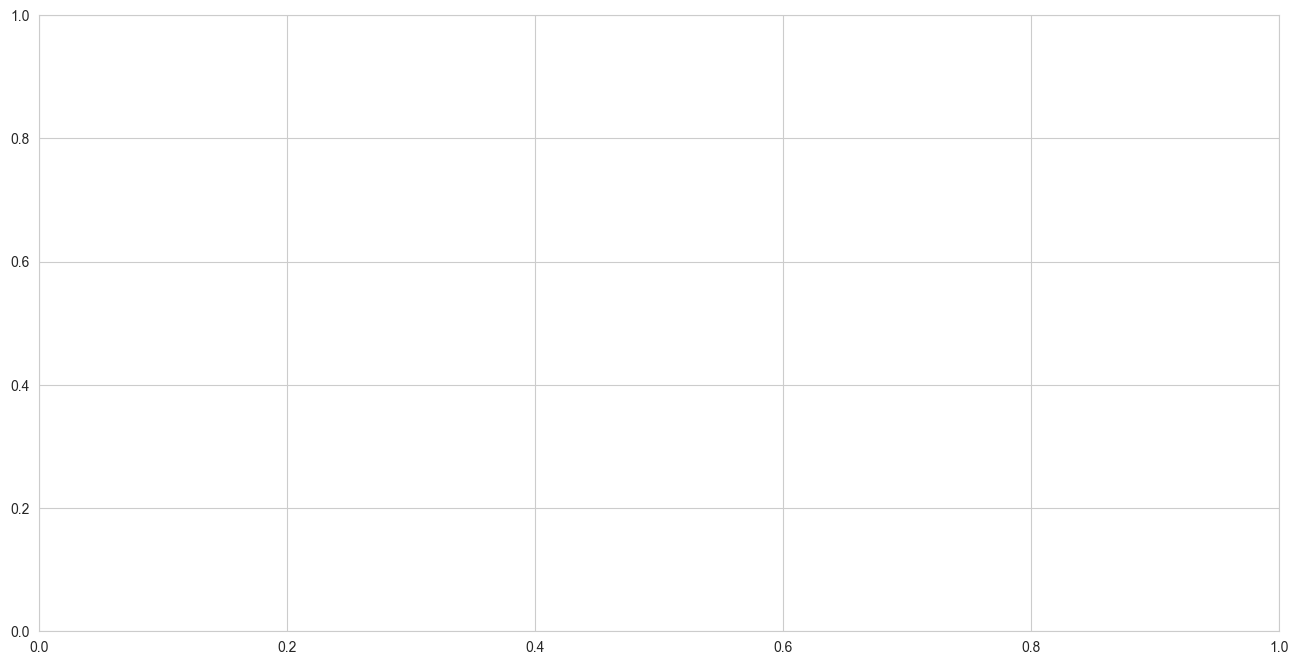

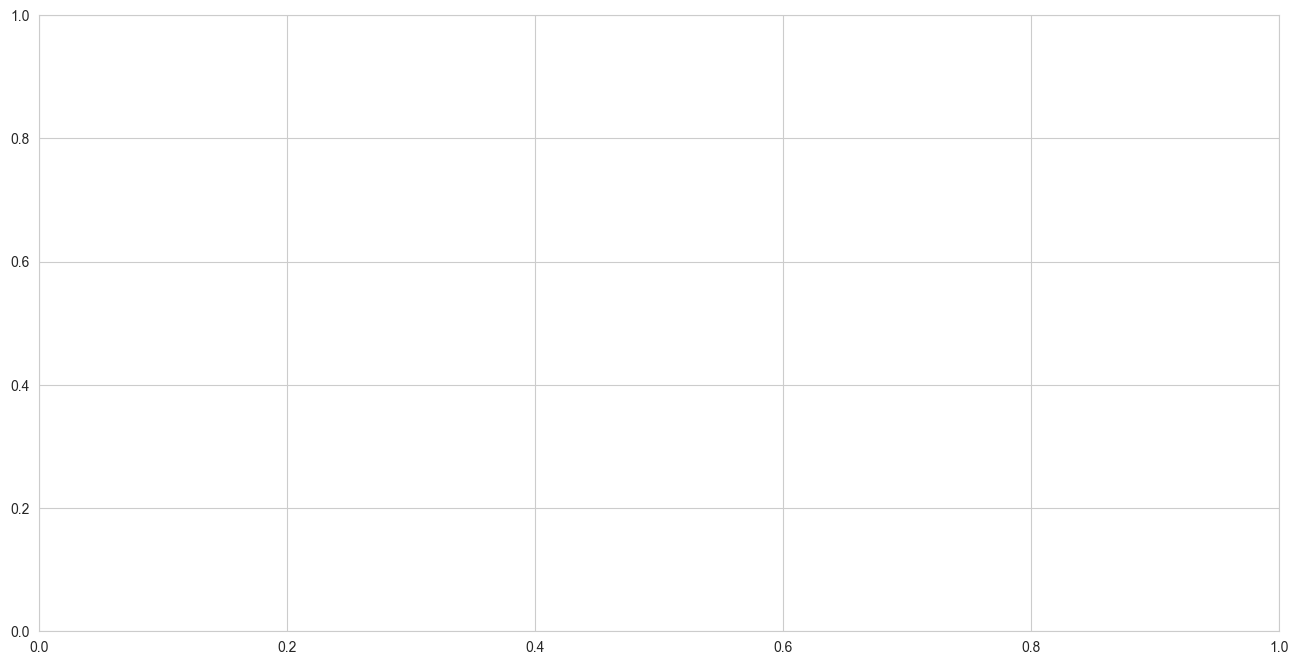

In [3]:
# Create and display the GUI
gui = create_comparison_gui()
display(gui)